In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Activation,SpatialDropout1D,Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# from tensorflow.keras.saving.hdf5_format import save_attributes_to_hdf5_group
import re
from transformers import BertTokenizer, TFBertModel

In [2]:
# !pip install WordCloud

In [3]:
# !pip install transformers

In [4]:
# pip install gensim

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import re

In [6]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

## Data Cleaning 

In [7]:
df = pd.read_csv('data.csv', header=None, names=['target', 'id', 'date', 'query', 'user', 'text'], encoding='latin1')

In [8]:
df = df.drop(columns=['id', 'date', 'query', 'user'], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


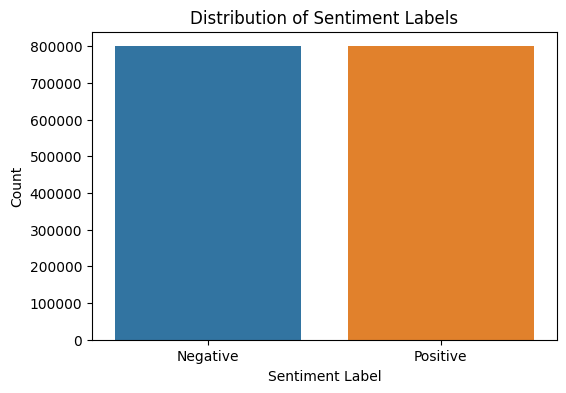

In [10]:
# Plot the distribution of target labels
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='target')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])  # Set custom x-axis labels
plt.show()

In [11]:
# Prepare the labels
df['target'] = df['target'].map(lambda x: 0 if x == 0 else 1)

### Data Cleaning

In [12]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

df['text'] = df.text.apply(preprocess_apply)

In [13]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(20) # Returns the rows with the index and display it

,target,text
789703,0,pipi pompom have big poops i m the one cleani...
917747,1,good morning jess here just wanted to say th...
612232,0,<user> what s wrong
839017,1,golfing with taylor chenelle and dustin toda...
654149,0,i don t feel like i should be awake bro is do...
500627,0,iam so happy to get off this plane jeez this...
684065,0,numbers on the mac really is pants 16k rows...
462296,0,<user> i m scared of ouija boards though amp...
684565,0,i m youtubing how to make mixed drinks because...
1125382,1,yess diversity i knew you could do it


###  Common words 

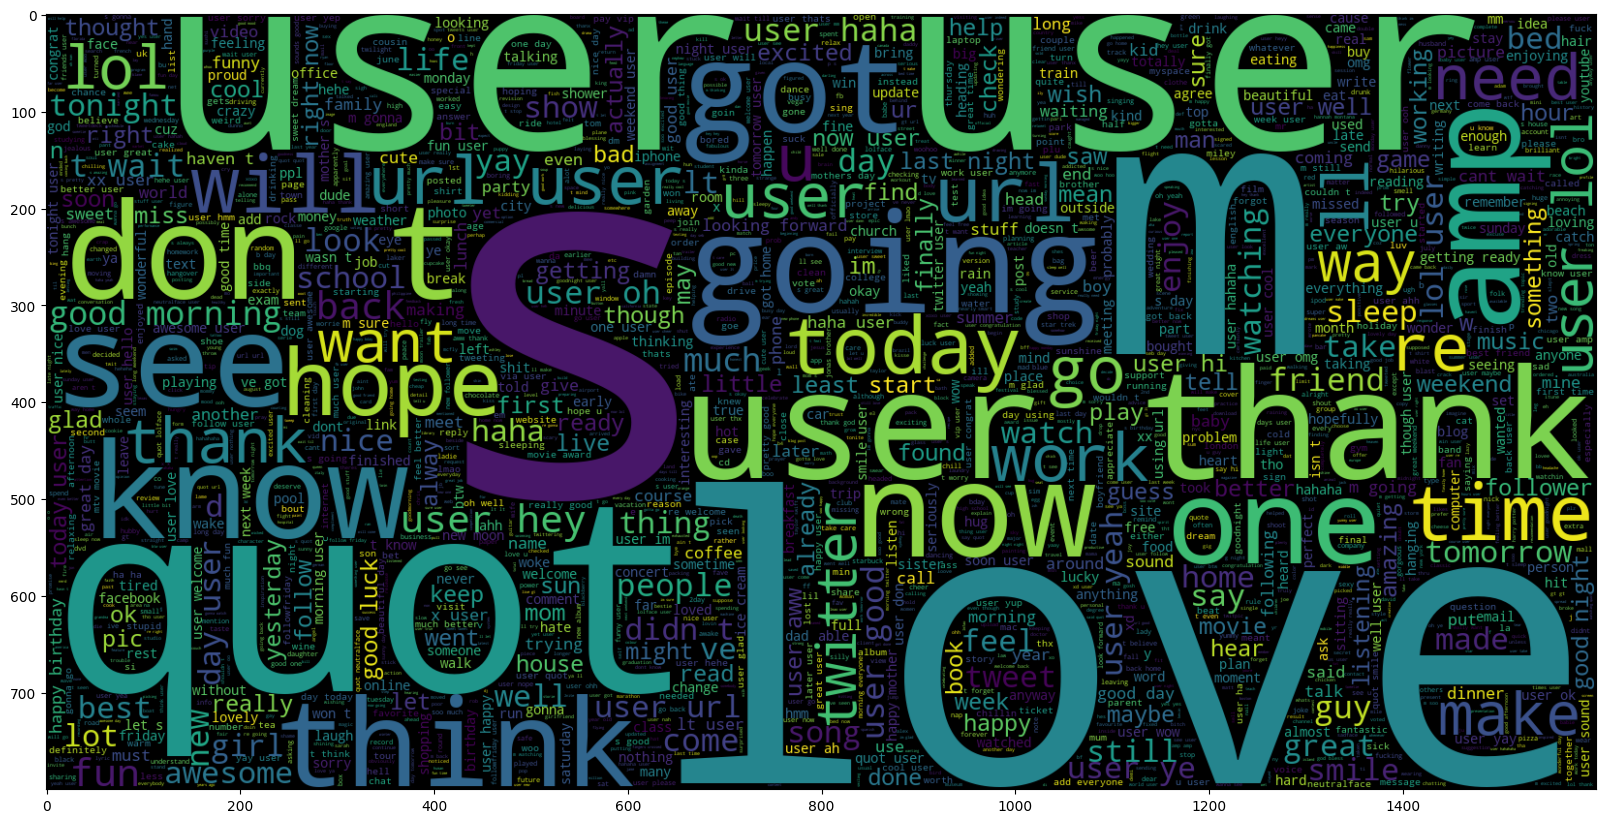

In [14]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target ==1].text))
plt.imshow(wc , interpolation = 'bilinear')
positive_tweets = df[df.target == 1]

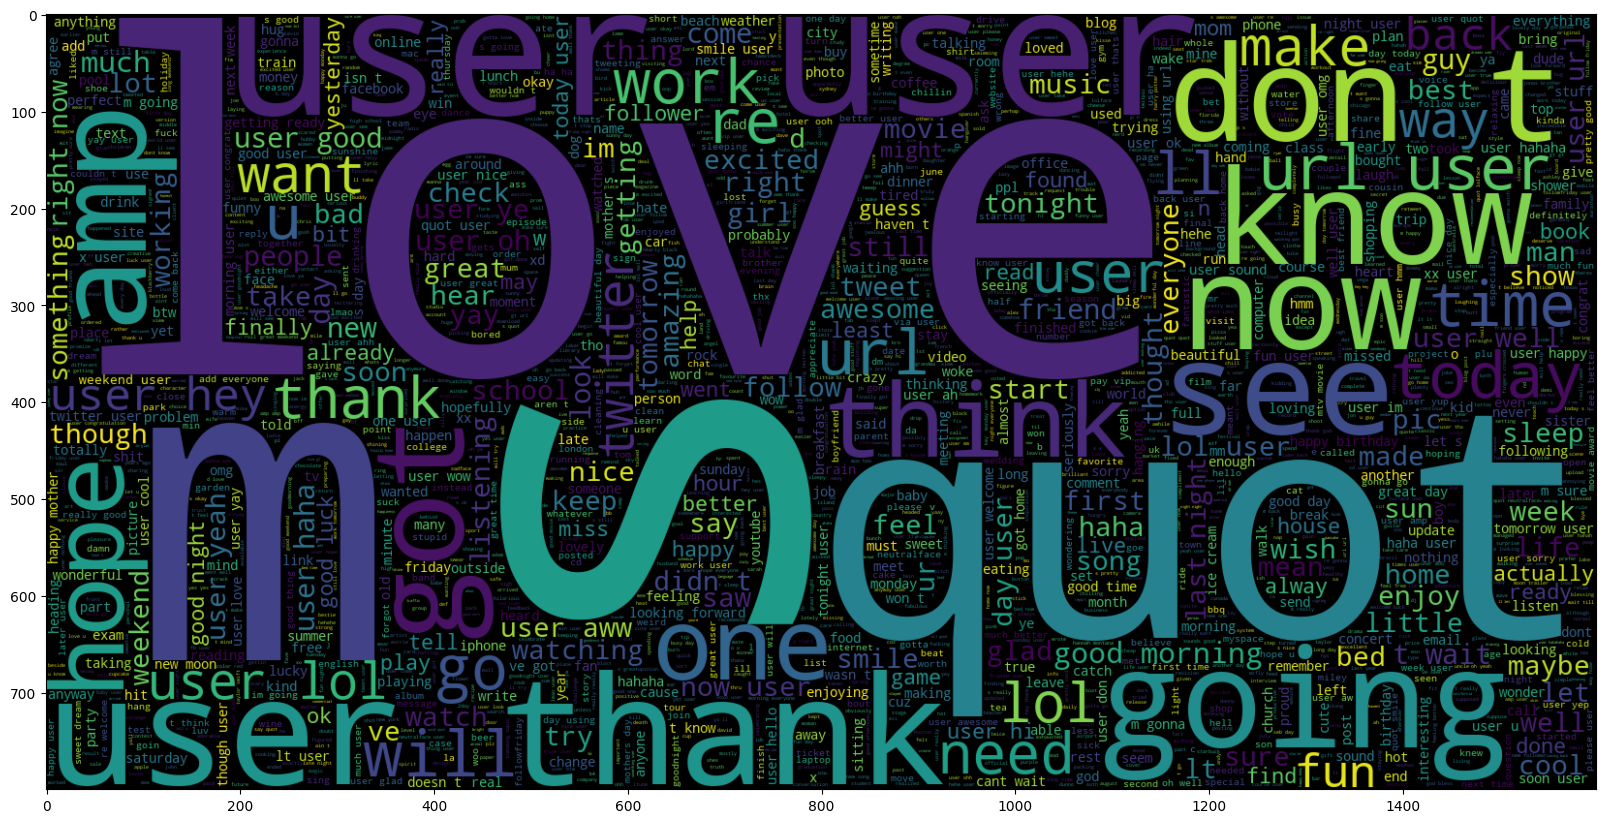

In [15]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

In [16]:
TRAIN_SIZE = 0.8
# MAX_NB_WORDS = 100000

In [17]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


### Pad and Tokenize Input  

In [18]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

# Calculate the maximum sequence length based on the number of tokens in each sequence
sequence_lengths = [len(text_sequence.split()) for text_sequence in train_data.text]
max_sequence_length = max(sequence_lengths)

print("Vocabulary Size:", vocab_size)
print("Max Sequence Length:", max_sequence_length)

MAX_SEQUENCE_LENGTH = max_sequence_length

Vocabulary Size: 228270
Max Sequence Length: 53


In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 53)
Testing X Shape: (320000, 53)


In [20]:
y_train = train_data.target
y_test = test_data.target

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000,)
y_test shape: (320000,)


### Word Embedding 

In [21]:
GLOVE_EMB = 'glove.6B/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = 'models/best_model.hdf5'

In [22]:
embeddings_index = {}

# Open the GloVe embeddings file with the appropriate encoding
with open(GLOVE_EMB, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [23]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [24]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                              EMBEDDING_DIM,
                                              weights=[embedding_matrix],
                                              input_length=MAX_SEQUENCE_LENGTH,
                                              trainable=False)

### Models for Test

Input Layer: You start with an embedding layer that converts your input sequences (text) into dense vectors. This is a common preprocessing step for text data.

Spatial Dropout: This layer helps prevent overfitting by randomly setting a fraction of the input units to 0 at each update during training, which helps to prevent overfitting.

Convolutional Layer: The convolutional layer extracts local patterns and features from the spatial data. Convolutional layers are often used for image data, and here you are applying it to your text data, possibly to capture certain n-gram patterns.

Bidirectional GRU Layer: This layer consists of two GRU (Gated Recurrent Unit) layers: one processing the input sequence in the original order and the other processing it in reverse order. This can help capture long-range dependencies in both directions and is particularly useful for sequence tasks.

Dense Layers: You have two dense layers with ReLU activations, which are common for introducing non-linearity in the model.

Dropout Layer: Dropout helps prevent overfitting by randomly setting a fraction of the input units to 0 at each update during training.

Output Layer: The final dense layer with a sigmoid activation produces the binary classification output.

In [25]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
def base_lstm_model():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(x)  # Normal LSTM
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(sequence_input, outputs)
    model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [27]:
def lstm_model():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(sequence_input, outputs)
    model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [28]:
def gru_model():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2))(x)  
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(sequence_input, outputs)
    model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [29]:
def train_model(model, train_data, train_labels, test_data, test_label):
    reduce_lr = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1)
    early_stopper = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Pass the instantiated model to the callbacks
    reduce_lr.set_model(model)
    early_stopper.set_model(model)
    
    history = model.fit(train_data, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS,
                        validation_data=(test_data, test_label), callbacks=[reduce_lr, early_stopper])
    
    return history


###   Model Evaluation

In [30]:
def evaluate_tensorflow_model(model, test_data, test_labels):
    loss, accuracy = model.evaluate(test_data, test_labels)
    return loss, accuracy

In [31]:
def generate_classification_report(predictions, test_labels):
    report = classification_report(test_labels, predictions)
    return report


def generate_confusion_matrix(predictions, test_labels):
    matrix = confusion_matrix(test_labels, predictions)
    return matrix

def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

In [32]:
def predict_sentiment(model, tokenizer,max_sequence_length, new_texts):
    # Make predictions
    new_sequences = tokenizer.texts_to_sequences(new_texts)
    new_padded = pad_sequences(new_sequences, maxlen=max_sequence_length)
    predictions = model.predict(new_padded)
    sentiments = ['Negative' if pred < 0.5 else 'Positive' for pred in predictions]
    polarity_scores = predictions.flatten()
    
    return sentiments, polarity_scores

## LSTM Model

In [33]:
# Build the LSTM model
run_baselstm_model = base_lstm_model()
run_baselstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 53)]              0         
                                                                 
 embedding (Embedding)       (None, 53, 300)           68481000  
                                                                 
 spatial_dropout1d (SpatialD  (None, 53, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 49, 64)            96064     
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 512)               33280     
                                                             

In [34]:
# Train the TensorFlow model
baselstm_history = train_model(run_baselstm_model,x_train, y_train, x_test, y_test)

Epoch 1/10
1250/1250 [==============================] - 162s 127ms/step - loss: 0.4772 - accuracy: 0.7692 - val_loss: 0.4283 - val_accuracy: 0.8007 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 159s 127ms/step - loss: 0.4344 - accuracy: 0.7971 - val_loss: 0.4120 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 159s 127ms/step - loss: 0.4206 - accuracy: 0.8051 - val_loss: 0.4025 - val_accuracy: 0.8152 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 160s 128ms/step - loss: 0.4131 - accuracy: 0.8097 - val_loss: 0.3999 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 164s 131ms/step - loss: 0.4072 - accuracy: 0.8131 - val_loss: 0.3955 - val_accuracy: 0.8202 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 159s 127ms/step - loss: 0.4036 - accuracy: 0.8154 - val_loss: 0.3949 - val_accuracy: 0.8198 - lr: 0.0010
Epoch 7/10
1250/1250 [============

In [35]:
# Evaluate the TensorFlow model
baselstm_loss, baselstm_accuracy = evaluate_tensorflow_model(run_baselstm_model, x_test, y_test)

10000/10000 [==============================] - 303s 30ms/step - loss: 0.3895 - accuracy: 0.8237


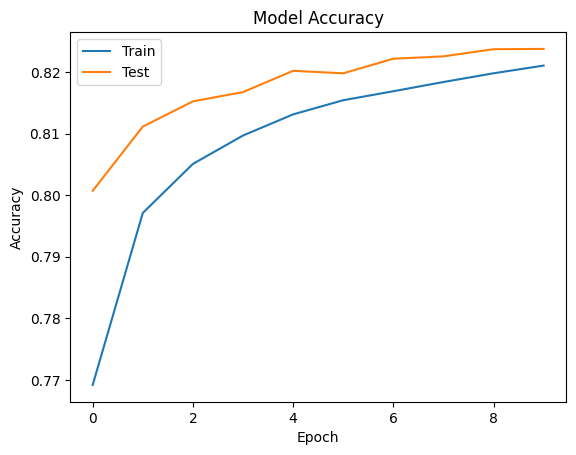

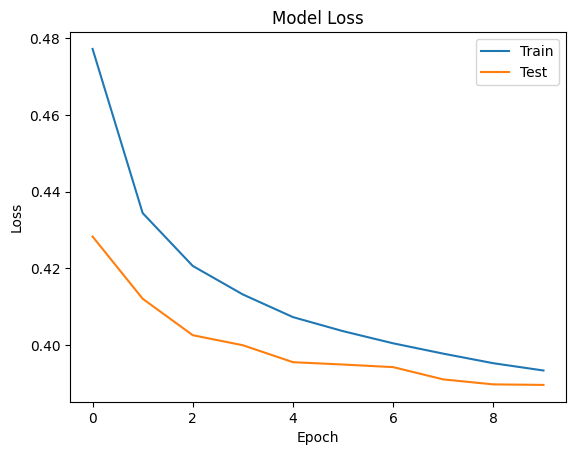

BASE LSTM Model
Loss: 0.38954055309295654
Accuracy: 0.8237281441688538



In [36]:
# Plot the history of the TensorFlow model
plot_history(baselstm_history)

print('BASE LSTM Model')
print('Loss:', baselstm_loss)
print('Accuracy:', baselstm_accuracy)
print()

In [37]:
run_baselstm_model.save('models/baselstm_model.h5')

In [38]:
predictions_baselstm = run_baselstm_model.predict(x_test)  
binary_predictions_baselstm = np.round(predictions_baselstm)  

10000/10000 [==============================] - 300s 30ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    160542
           1       0.81      0.84      0.83    159458

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

Confusion Matrix:


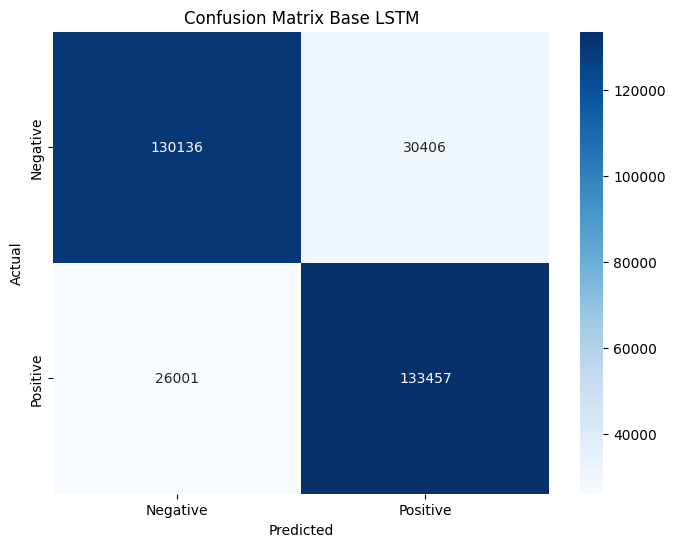

In [39]:
# Generate classification report
classification_baselstm = generate_classification_report(binary_predictions_baselstm, y_test)
print("Classification Report:")
print(classification_baselstm)

# Generate confusion matrix
confusion_baselstm = generate_confusion_matrix(binary_predictions_baselstm, y_test)
print("Confusion Matrix:")
confusion_baselstm
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_baselstm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix Base LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## BIDIRECTIONAL LSTM Model

In [40]:
# Build the LSTM model
run_lstm_model = lstm_model()
run_lstm_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 53)]              0         
                                                                 
 embedding (Embedding)       (None, 53, 300)           68481000  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 53, 300)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 512)               6604

In [41]:
# Train the TensorFlow model
lstm_history = train_model(run_lstm_model,x_train, y_train, x_test, y_test)

Epoch 1/10
1250/1250 [==============================] - 309s 246ms/step - loss: 0.4752 - accuracy: 0.7700 - val_loss: 0.4241 - val_accuracy: 0.8032 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 307s 246ms/step - loss: 0.4315 - accuracy: 0.7993 - val_loss: 0.4105 - val_accuracy: 0.8099 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 307s 246ms/step - loss: 0.4189 - accuracy: 0.8068 - val_loss: 0.4013 - val_accuracy: 0.8166 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 307s 246ms/step - loss: 0.4104 - accuracy: 0.8115 - val_loss: 0.3980 - val_accuracy: 0.8187 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 307s 246ms/step - loss: 0.4055 - accuracy: 0.8141 - val_loss: 0.3965 - val_accuracy: 0.8180 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 307s 245ms/step - loss: 0.4009 - accuracy: 0.8169 - val_loss: 0.3920 - val_accuracy: 0.8218 - lr: 0.0010
Epoch 7/10
1250/1250 [============

In [42]:
# Evaluate the TensorFlow model
lstm_loss, lstm_accuracy = evaluate_tensorflow_model(run_lstm_model, x_test, y_test)

10000/10000 [==============================] - 583s 58ms/step - loss: 0.3878 - accuracy: 0.8253


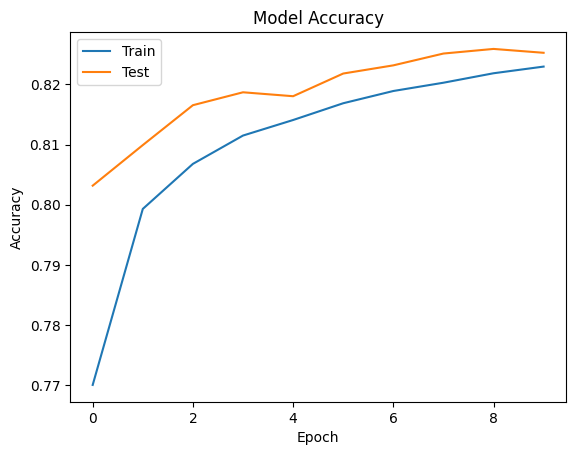

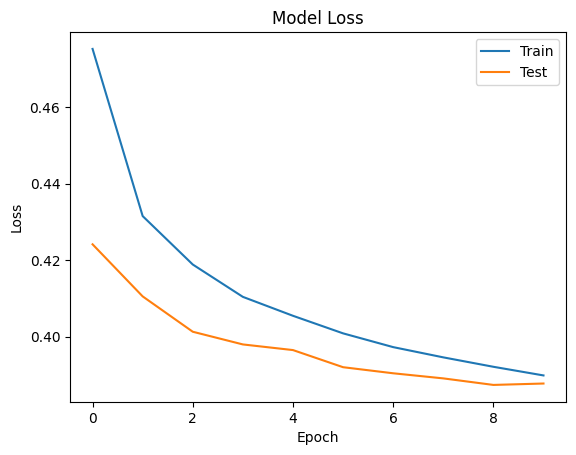

TensorFlow Model
Loss: 0.38778719305992126
Accuracy: 0.825265645980835



In [43]:
# Plot the history of the TensorFlow model
plot_history(lstm_history)

print('TensorFlow Model')
print('Loss:', lstm_loss)
print('Accuracy:', lstm_accuracy)
print()

In [44]:
run_lstm_model.save('models/lstm_model.h5')

In [45]:
predictions_lstm = run_lstm_model.predict(x_test)  
binary_predictions_lstm = np.round(predictions_lstm)  # Round predictions for binary classification


10000/10000 [==============================] - 585s 58ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83    160542
           1       0.84      0.80      0.82    159458

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000

Confusion Matrix:


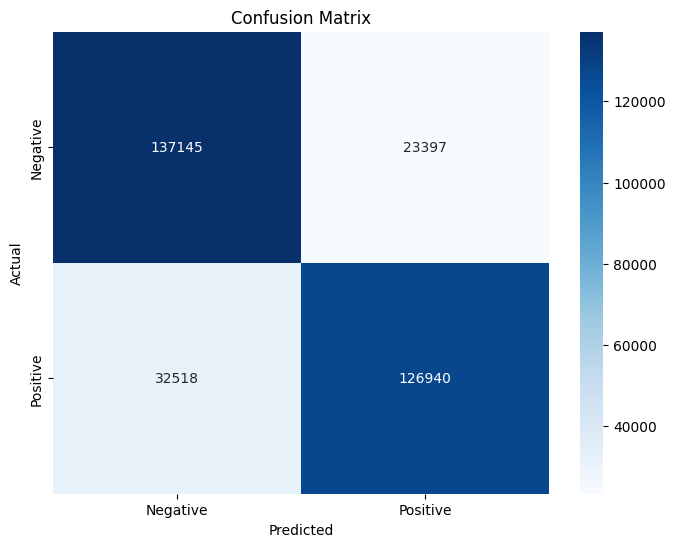

In [46]:
# Generate classification report
classification_rep = generate_classification_report(binary_predictions_lstm, y_test)
print("Classification Report:")
print(classification_rep)

# Generate confusion matrix
confusion_mat = generate_confusion_matrix(binary_predictions_lstm, y_test)
print("Confusion Matrix:")
confusion_mat
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### BIDIRECTIONAL GRU Model 

In [47]:
# Build the LSTM model
run_gru_model = gru_model()
run_gru_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 53)]              0         
                                                                 
 embedding (Embedding)       (None, 53, 300)           68481000  
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 53, 300)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 49, 64)            96064     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              49920     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 512)               6604

In [48]:
# Build the LSTM model
run_gru_model = gru_model()

# Train the TensorFlow model
gru_history = train_model(run_gru_model,x_train, y_train, x_test, y_test)

Epoch 1/10
1250/1250 [==============================] - 285s 227ms/step - loss: 0.4788 - accuracy: 0.7680 - val_loss: 0.4282 - val_accuracy: 0.8001 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 281s 225ms/step - loss: 0.4356 - accuracy: 0.7969 - val_loss: 0.4113 - val_accuracy: 0.8107 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 280s 224ms/step - loss: 0.4224 - accuracy: 0.8046 - val_loss: 0.4025 - val_accuracy: 0.8157 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 280s 224ms/step - loss: 0.4141 - accuracy: 0.8092 - val_loss: 0.3974 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 280s 224ms/step - loss: 0.4087 - accuracy: 0.8126 - val_loss: 0.3974 - val_accuracy: 0.8186 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 281s 225ms/step - loss: 0.4051 - accuracy: 0.8146 - val_loss: 0.3923 - val_accuracy: 0.8217 - lr: 0.0010
Epoch 7/10
1250/1250 [============

In [49]:
# Evaluate the TensorFlow model
gru_loss, gru_accuracy = evaluate_tensorflow_model(run_gru_model, x_test, y_test)

10000/10000 [==============================] - 544s 54ms/step - loss: 0.3868 - accuracy: 0.8255


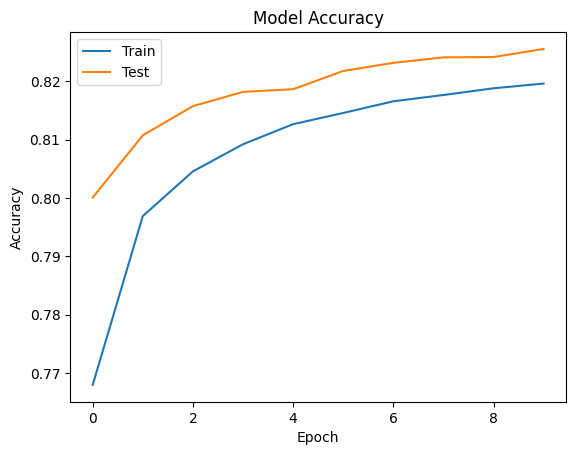

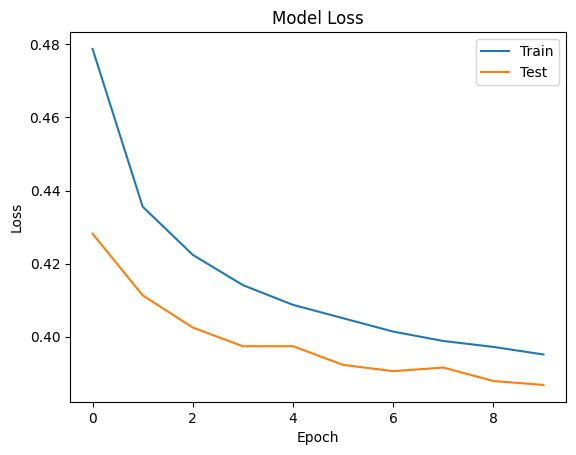

TensorFlow Model
Loss: 0.3868044316768646
Accuracy: 0.8255312442779541



In [50]:
# Plot the history of the TensorFlow model
plot_history(gru_history)

print('TensorFlow Model')
print('Loss:', gru_loss)
print('Accuracy:', gru_accuracy)
print()

In [51]:
run_gru_model.save('models/gru_model.h5')

In [52]:
predictions_gru = run_gru_model.predict(x_test)  
binary_predictions_gru = np.round(predictions_gru)  # Round predictions for binary classification

10000/10000 [==============================] - 541s 54ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82    160542
           1       0.82      0.83      0.83    159458

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000

Confusion Matrix:


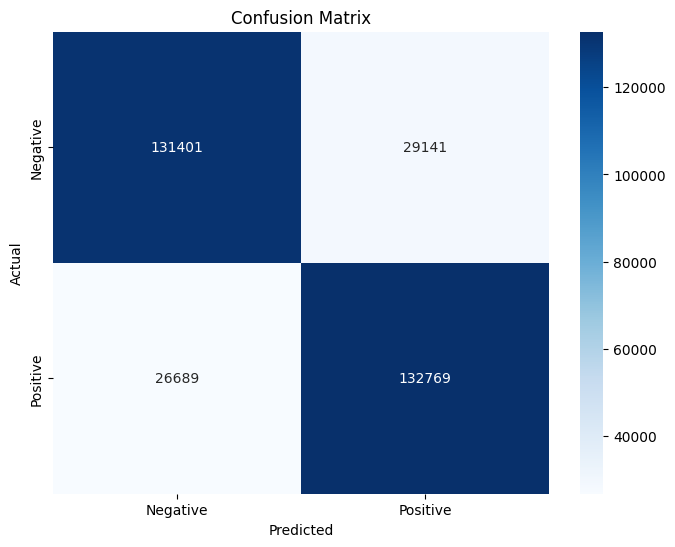

In [53]:
# Generate classification report
classification_rep_gru = generate_classification_report(binary_predictions_gru, y_test)
print("Classification Report:")
print(classification_rep_gru)

# Generate confusion matrix
confusion_mat_gru = generate_confusion_matrix(binary_predictions_gru, y_test)
print("Confusion Matrix:")
confusion_mat_gru
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_gru, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##  Predict 

In [56]:
# Load the trained models
test_baselstm_model = tf.keras.models.load_model("models/baselstm_model.h5")
test_lstm_model = tf.keras.models.load_model("models/lstm_model.h5")
test_gru_model = tf.keras.models.load_model("models/gru_model.h5")

# New texts to predict
new_texts = ['This is a positive tweet!', 'I am not happy', 'I love you', 
             'I hate you','I am doing great', 'I love my country']

# Initialize lists to store results
results = []

# Loop through new texts
for text in new_texts:
    # Predict sentiment using BASE LSTM model
    sentiment_baselstm, polarity_baselstm = predict_sentiment(test_baselstm_model, tokenizer, MAX_SEQUENCE_LENGTH, [text])
    
    # Predict sentiment using LSTM model
    sentiment_lstm, polarity_lstm = predict_sentiment(test_lstm_model, tokenizer, MAX_SEQUENCE_LENGTH, [text])
    
    # Predict sentiment using GRU model
    sentiment_gru, polarity_gru = predict_sentiment(test_gru_model, tokenizer, MAX_SEQUENCE_LENGTH, [text])
    
    # Append results to the list
    results.append({
        'Text': text,
        'BASE LSTM Sentiment': sentiment_baselstm[0],
        'BASE LSTM Polarity Score': polarity_baselstm[0],
        'LSTM Sentiment': sentiment_lstm[0],
        'LSTM Polarity Score': polarity_lstm[0],
        'GRU Sentiment': sentiment_gru[0],
        'GRU Polarity Score': polarity_gru[0]
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Display the DataFrame
results_df


1/1 [==============================] - 0s 54ms/step


,Text,BASE LSTM Sentiment,BASE LSTM Polarity Score,LSTM Sentiment,LSTM Polarity Score,GRU Sentiment,GRU Polarity Score
0,This is a positive tweet!,Positive,0.978937,Positive,0.962897,Positive,0.987872
1,I am not happy,Negative,0.007803,Negative,0.008220,Negative,0.002789
2,I love you,Positive,0.928608,Positive,0.891066,Positive,0.927692
3,I hate you,Negative,0.023970,Negative,0.031756,Negative,0.035196
4,I am doing great,Positive,0.977079,Positive,0.959700,Positive,0.986365
5,I love my country,Positive,0.990763,Positive,0.983648,Positive,0.984477


In [55]:
# # Load the trained models
# test_baselstm_model = tf.keras.models.load_model("models/baselstm_model.h5")
# test_lstm_model = tf.keras.models.load_model("models/lstm_model.h5")
# test_gru_model = tf.keras.models.load_model("models/gru_model.h5")

# # New texts to predict
# new_texts = ['This is a positive tweet!', 'I am not happy', 'I love you', 'I hate you']

# # Loop through new texts
# for text in new_texts:
#     #BASE LSTM 
#     sentiment_baselstm, polarity_baselstm = predict_sentiment(test_baselstm_model, tokenizer, MAX_SEQUENCE_LENGTH, [text])
    
#     # Predict sentiment using LSTM model
#     sentiment_lstm, polarity_lstm = predict_sentiment(test_lstm_model, tokenizer, MAX_SEQUENCE_LENGTH, [text])
    
#     # Predict sentiment using GRU model
#     sentiment_gru, polarity_gru = predict_sentiment(test_gru_model, tokenizer, MAX_SEQUENCE_LENGTH, [text])
    
#     # Display results
#     print('Text:', text)
    
#     print('BASE LSTM Sentiment:', sentiment_baselstm[0])
#     print('BASE LSTM Polarity Score:', polarity_baselstm[0])
#     print('LSTM Sentiment:', sentiment_lstm[0])
#     print('LSTM Polarity Score:', polarity_lstm[0])
#     print('GRU Sentiment:', sentiment_gru[0])
#     print('GRU Polarity Score:', polarity_gru[0])
#     print()